In [1]:
import pathlib
import re

import pandas as pd
import json

def getType(filename):
    match = re.match(r'([A-Z]+[0-9])', filename)
    if match:
        return match.group(1)
    return None


# Load the JSON file
result_dir = pathlib.Path()/"results"
result_filenames = [f.name for f in result_dir.iterdir() if f.is_file()]
instance_names_without_ext = [filename[:-5] for filename in result_filenames]

result_dict_list = []
time_series_dfs = {}
for instance_name in instance_names_without_ext:
    result_filepath = result_dir/(instance_name+".json")
    data = None
    with open(result_filepath.absolute(), 'r') as f:
        data = json.load(f)
    time_series_keys = [
        'bestBsvCostHistory',
        'bestPreBsvCostHistory',
        "bestTotalCostHistory"
    ]
    # Convert each long history list to a DataFrame or Series
    time_series_dfs[instance_name] = {}
    for key in time_series_keys:
        if key in data:
        # As DataFrame with iteration index
            time_series_dfs[instance_name][key] = pd.DataFrame({
                'iteration': range(len(data[key])),
                key: data[key]
            })

    entry = {"Instance": instance_name,
             "Total Cost": data["bestTotalCostHistory"][-1],
             "Bsv Cost": data["bestBsvCostHistory"][-1],
             "Total Time": data["totalElapsedTime"]/1000,
             "DP Time": data["dpElapsedTime"]/1000,
             "IP Time": data["ipElapsedTime"]/1000,
             "NDPI Time": data["ndpiElapsedTime"]/1000,
             "Local Search Time": data["localSearchElapsedTime"]/1000,
             "ALNS Operator Time": data["alnsOperatorElapsedTime"]/1000,
             "Type": getType(instance_name)
             }
    result_dict_list.append(entry)

result_df = pd.DataFrame(result_dict_list)

In [2]:
result_df.to_csv("all_results.csv")

In [22]:
time_columns = [col for col in result_df.columns if 'Time' in col]
mean_time_by_type = result_df.groupby('Type')[time_columns].mean()

In [23]:
mean_time_by_type

,Total Time,DP Time,IP Time,NDPI Time,Local Search Time,ALNS Operator Time
Type,,,,,,
C1,2151.273292,1984.066935,132.739471,1.377909,1.664417,0.424632
C2,1304.553535,1291.763987,3.461995,1.653033,0.913253,0.236964
R1,1667.916586,1370.293673,275.433197,5.416102,1.459329,0.518581
R2,2690.827609,2679.035236,4.527451,0.041664,1.269438,0.281705
RC1,242.193467,209.988006,25.486889,0.032634,0.353039,0.230363
RC2,3241.901838,2867.757498,1.086377,81.876549,0.780917,0.328807


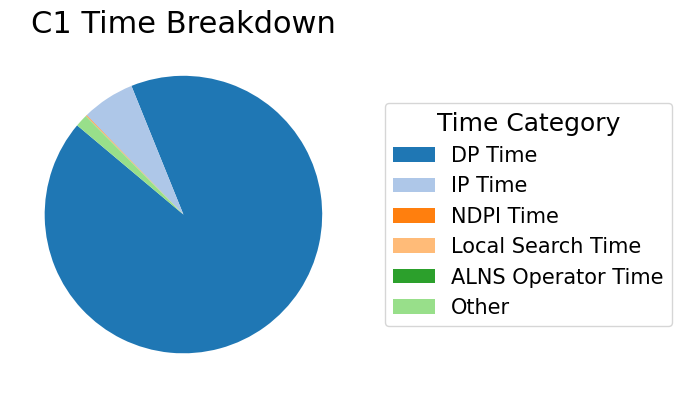

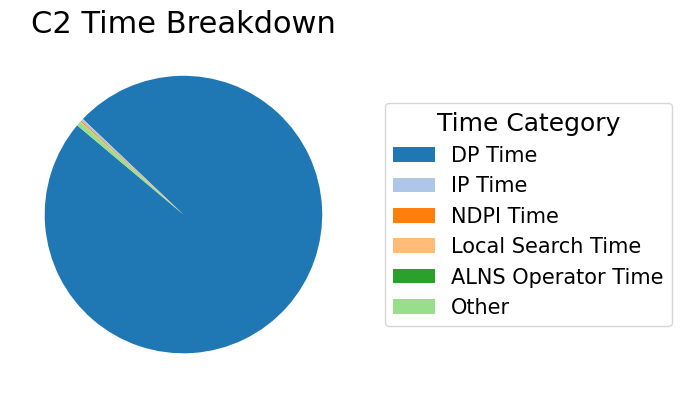

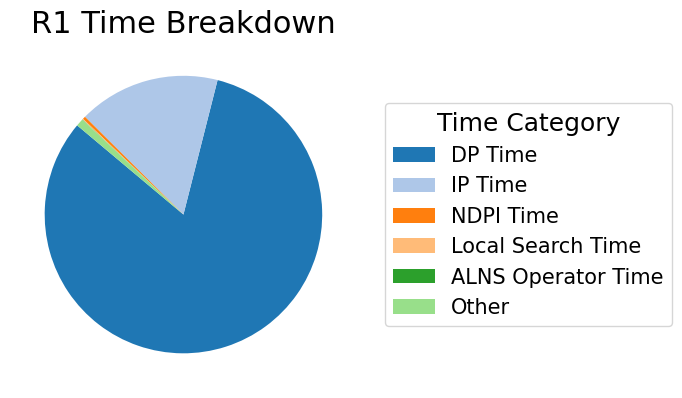

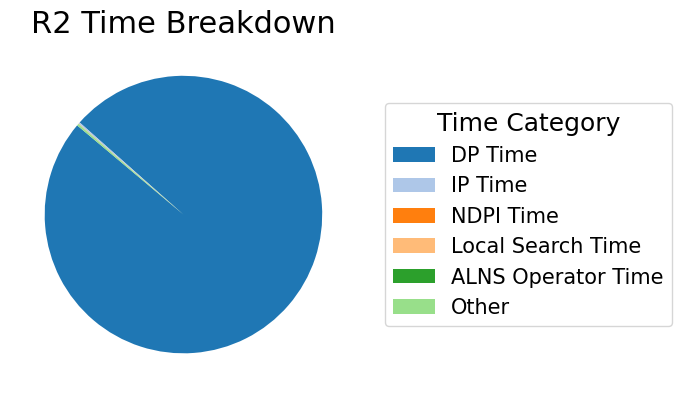

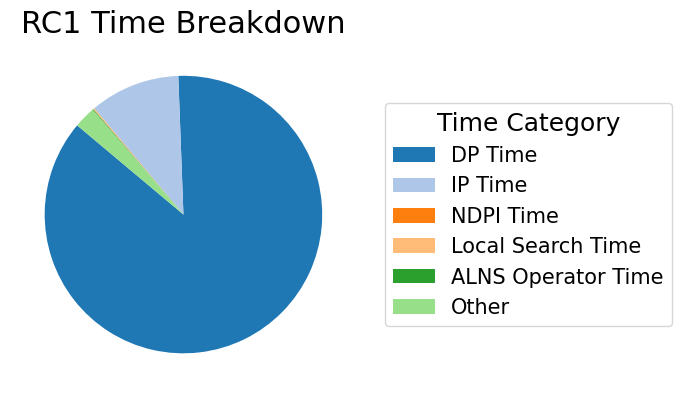

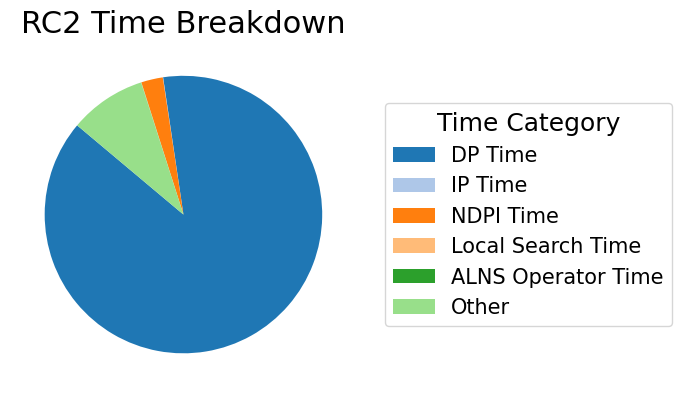

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

types = ['C1', 'C2', 'R1', 'R2', 'RC1', 'RC2']
df = pd.DataFrame(mean_time_by_type, index=types)
labels = ['DP Time', 'IP Time', 'NDPI Time', 'Local Search Time', 'ALNS Operator Time', 'Other']

# Pick a colormap for consistent colors
colors = plt.get_cmap('tab20').colors[:len(labels)]

for type_name, row in df.iterrows():
    subtimes = row[1:]
    subtime_sum = subtimes.sum()
    other = max(row['Total Time'] - subtime_sum, 0)
    use_labels = labels if other > 0 else labels[:-1]
    use_values = list(subtimes) + ([other] if other > 0 else [])
    use_colors = colors[:len(use_labels)]

    fig, ax = plt.subplots(figsize=(7, 7))
    # Do NOT show labels or autopct inside pie!
    wedges, _ = ax.pie(
        use_values,
        labels=None,      # No labels
        colors=use_colors,
        startangle=140
    )

    ax.set_title(f"{type_name} Time Breakdown", fontsize=22)
    # Add legend outside to the right
    ax.legend(
        wedges, use_labels, 
        title="Time Category", 
        loc='center left', 
        bbox_to_anchor=(1.05, 0.5), 
        fontsize=15, 
        title_fontsize=18
    )
    plt.tight_layout()
    plt.savefig(f"{type_name}_pie.png", dpi=180, bbox_inches='tight')
    plt.show()
